# Clustering Kleister-Charity with TfidfVectorizer and MiniBatchKMeans

The approach I took is based upon: https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans

In [1]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
#Thanks @Maarten Fish for providing me with this csv file, because the original tsv file wouldn't load

data = pd.read_csv("wim.csv")

In [3]:
#delete a nonsense column

del data["Unnamed: 0"]

In [4]:
#display the dataset
data

,File,Raw
0,008482cf51383c158b54e593cfa5fbf7.pdf,CHARITY\nTrustees' Annual Report for the perio...
1,009fab39d746267b6de8428366fe4b02.pdf,Charity Name\nNo lif anv)\nStepping Stone Thea...
2,01c7fd563327947c68abdd9717ef228d.pdf,Promoting Independent Living\nAbility\nAbility...
3,01d804edf76bec4912d2466908a60889.pdf,Annua Report &\nAccounts 2017/18\nYear ended 3...
4,01e4461b059e707b7d8276b3d2b80b71.pdf,"The Greenway Centre\n(Registered charity, numb..."
...,...,...
1723,ff80d979460073ac05715369dbe22137.pdf,CHARITY\nTrustees' Annual Report for the perio...
1724,ffa189b0b5609aef00997cf734673ea3.pdf,The Gordon Russell Trust\nCharity No. 326446\n...
1725,ffb1325d77fde527581429bb28322205.pdf,FRIENDS OF EZRA\nCharity No\nCHARITY\n(if any)...
1726,ffbf63bf6483012f2fd0af6c77ab3da6.pdf,CASPARI FOUNDATION\n(Company Number 3815700)\n...


In [5]:
#apply the imported TfidfVectorizer, fit and transform the text data
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(data.Raw)
text = tfidf.transform(data.Raw)

Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters


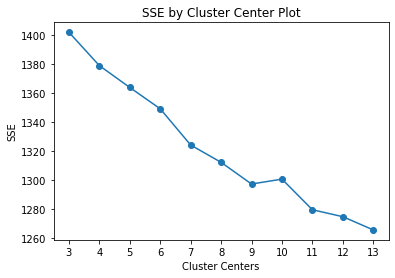

In [10]:
#Using the elbow method to find an optimum amount of clusters

def find_optimal_clusters(data, max_k):
    iters = range(3, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 13)


=> 9 clusters seems an optimum

Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters
Fit 21 clusters


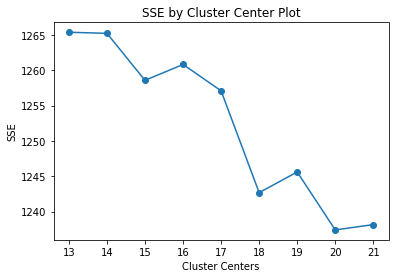

In [11]:
#Using the elbow method to find an optimum amount of clusters

def find_optimal_clusters(data, max_k):
    iters = range(13, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 21)


=> 18 and also 20 seems a nice amount of clusters too, I will try 3 times with these amount of clusters

In [12]:
#Perform the MiniBatchKMeans algorithm with the chosen 9 clusters

clusters = MiniBatchKMeans(n_clusters=9, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

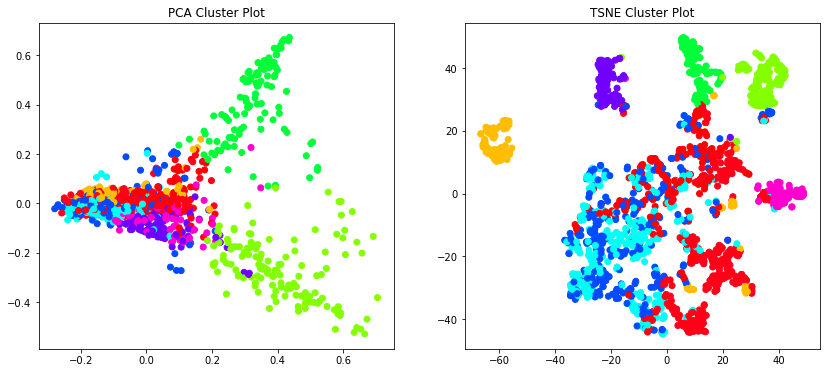

In [13]:
#Plot the clusters for PCA and TSNE: 
#"One plot uses PCA which is better at capturing global structure of the data. 
# The other uses TSNE which is better at capturing relations between neighbors."

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=1728, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=5).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=1728, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [14]:
#Get a sense of the text contents of each cluster

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
ntotal,act,examiner,30,statements,accounting,000,ended,ne,trust

Cluster 1
scheme,statements,31,ne,000,august,pupils,governors,college,school

Cluster 2
account,50,nf,club,2017,school,nf0,ne,n0,00

Cluster 3
nmarch,information,nname,npara,ndetails,nto,ntar,nsection,nearest,optional

Cluster 4
resources,ntotal,2015,march,ended,2014,31,statements,company,ne

Cluster 5
company,income,n2017,ended,ntotal,2018,31,statements,2017,ne

Cluster 6
fund,baptist,ntotal,parish,st,nchurch,december,ne,pcc,church

Cluster 7
2016,nfunds,assets,31,statements,march,000,ntotal,ne,n0

Cluster 8
income,support,2016,2017,31,company,statements,ne,march,000


In [15]:
#Having a look at the amount of text documents in each cluster, thanks @Maarten Fish for this code
unique, counts = np.unique(clusters, return_counts=True)
dict(zip(unique, counts))


{0: 169, 1: 133, 2: 139, 3: 114, 4: 321, 5: 317, 6: 103, 7: 73, 8: 359}

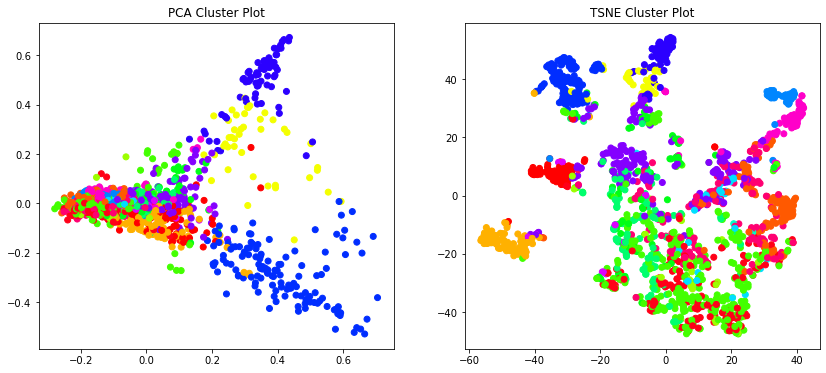

In [16]:
#Perform the MiniBatchKMeans algorithm with the chosen 18 clusters



clusters = MiniBatchKMeans(n_clusters=18, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

#Plot the clusters for PCA and TSNE: 

#"One plot uses PCA which is better at capturing global structure of the data. 

# The other uses TSNE which is better at capturing relations between neighbors."


def plot_tsne_pca(data, labels):

    max_label = max(labels)

    max_items = np.random.choice(range(data.shape[0]), size=1728, replace=False)

    

    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())

    tsne = TSNE().fit_transform(PCA(n_components=5).fit_transform(data[max_items,:].todense()))

    

    

    idx = np.random.choice(range(pca.shape[0]), size=1728, replace=False)

    label_subset = labels[max_items]

    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]

    

    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    

    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)

    ax[0].set_title('PCA Cluster Plot')

    

    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)

    ax[1].set_title('TSNE Cluster Plot')

    

plot_tsne_pca(text, clusters)



In [17]:
#Get a sense of the text contents of each cluster

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
31st,2016,31,assets,statements,march,000,ntotal,ne,n0

Cluster 1
care,group,2017,ne,statements,company,31,march,housing,000

Cluster 2
fund,baptist,ntotal,parish,st,nchurch,december,ne,pcc,church

Cluster 3
nnames,ncharity,ntar,nadditional,information,nname,nsection,00,optional,npara

Cluster 4
limited,2006,ended,act,december,directors,31,statements,companies,company

Cluster 5
company,income,costs,2018,ended,ntotal,31,2017,statements,ne

Cluster 6
act,fund,accounting,pre,examiner,2014,31,trust,ne,school

Cluster 7
accounting,charitable,ntotal,000,statements,ended,june,30,trust,ne

Cluster 8
nhs,cheltenham,diagnosis,ne,scanner,cancer,imaging,mri,ncobalt,cobalt

Cluster 9
artistic,artists,statements,ne,march,hippodrome,company,arts,festival,theatre

Cluster 10
statements,income,school,governors,ne,scheme,ncollege,pupils,000,college

Cluster 11
account,50,2014,nf,2017,club,nf0,ne,n0,00

Cluster 12
payments,nmarch,nsub,receipts,ndetails,ntar,nto,nsection,nearest,optional

Clust

In [18]:
#Having a look at the amount of text documents in each cluster, thanks @Maarten Fish for this code
unique, counts = np.unique(clusters, return_counts=True)
dict(zip(unique, counts))


{0: 70,
 1: 115,
 2: 100,
 3: 43,
 4: 31,
 5: 307,
 6: 76,
 7: 110,
 8: 5,
 9: 30,
 10: 45,
 11: 133,
 12: 74,
 13: 201,
 14: 17,
 15: 69,
 16: 153,
 17: 149}

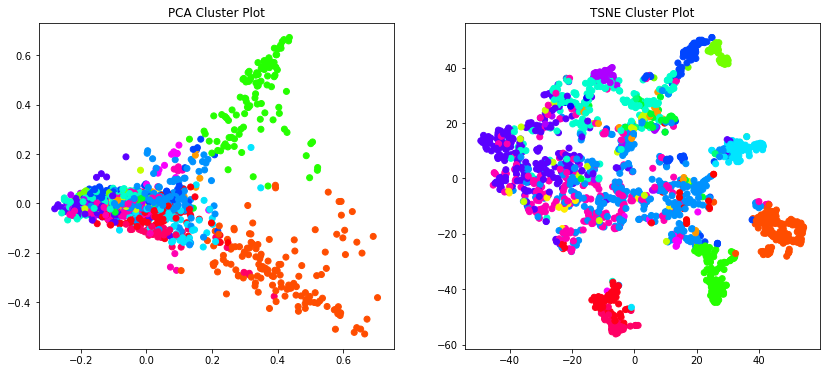

In [19]:
#Perform the MiniBatchKMeans algorithm with the chosen 18 clusters


clusters = MiniBatchKMeans(n_clusters=20, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)



#Plot the clusters for PCA and TSNE: 



#"One plot uses PCA which is better at capturing global structure of the data. 



# The other uses TSNE which is better at capturing relations between neighbors."





def plot_tsne_pca(data, labels):



    max_label = max(labels)



    max_items = np.random.choice(range(data.shape[0]), size=1728, replace=False)



    


    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())


    tsne = TSNE().fit_transform(PCA(n_components=5).fit_transform(data[max_items,:].todense()))



    



    



    idx = np.random.choice(range(pca.shape[0]), size=1728, replace=False)

    label_subset = labels[max_items]


    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]


    



    f, ax = plt.subplots(1, 2, figsize=(14, 6))



    


    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)



    ax[0].set_title('PCA Cluster Plot')



    



    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)



    ax[1].set_title('TSNE Cluster Plot')



    



plot_tsne_pca(text, clusters)







In [20]:
#Get a sense of the text contents of each cluster

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
ntotal,red,appeal,lord,mayor,syndrome,nleeds,choir,whale,leeds

Cluster 1
account,50,school,nf,2017,club,nf0,n0,ne,00

Cluster 2
ne,patients,research,ncobalt,breast,000,cobalt,hospital,cancer,ms

Cluster 3
charitable,ended,riding,norman,trust,almshouse,dawson,30,ne,june

Cluster 4
000,arts,festival,eye,nurban,march,ne,company,hippodrome,theatre

Cluster 5
statements,income,school,governors,ne,scheme,ncollege,pupils,000,college

Cluster 6
nmarch,information,nname,ndetails,npara,nto,ntar,nsection,nearest,optional

Cluster 7
nand,cross,ncmi,relief,nislamic,cmi,islamic,000,farm,africa

Cluster 8
nprofessor,medical,fmedsci,nkidney,kidney,nfm,heart,academy,research,bhf

Cluster 9
income,assets,2017,company,2018,31,march,statements,000,ne

Cluster 10
31st,31,nfunds,assets,statements,march,000,ntotal,ne,n0

Cluster 11
income,2018,march,ntotal,2016,ended,31,statements,2017,ne

Cluster 12
pre,statements,schools,31,000,ne,august,pupils,governors,school

Cluster 13
statements,ended,nfor

In [21]:
#Having a look at the amount of text documents in each cluster, thanks @Maarten Fish for this code
unique, counts = np.unique(clusters, return_counts=True)
dict(zip(unique, counts))


{0: 18,
 1: 139,
 2: 22,
 3: 19,
 4: 28,
 5: 45,
 6: 109,
 7: 29,
 8: 10,
 9: 169,
 10: 69,
 11: 325,
 12: 90,
 13: 3,
 14: 241,
 15: 52,
 16: 15,
 17: 230,
 18: 48,
 19: 67}

Below I wanted to start code on metrics, but I have to continue working on it.

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(text)

In [7]:
dist

array([[-2.22044605e-16,  7.17891411e-01,  8.83021366e-01, ...,
         7.22123267e-01,  8.84227646e-01,  8.83304037e-01],
       [ 7.17891411e-01,  0.00000000e+00,  8.91945318e-01, ...,
         8.98096172e-01,  9.01871269e-01,  9.20682537e-01],
       [ 8.83021366e-01,  8.91945318e-01, -6.66133815e-16, ...,
         8.45598304e-01,  7.78426140e-01,  7.55976699e-01],
       ...,
       [ 7.22123267e-01,  8.98096172e-01,  8.45598304e-01, ...,
         0.00000000e+00,  7.88536890e-01,  8.05221337e-01],
       [ 8.84227646e-01,  9.01871269e-01,  7.78426140e-01, ...,
         7.88536890e-01,  1.11022302e-16,  7.36245308e-01],
       [ 8.83304037e-01,  9.20682537e-01,  7.55976699e-01, ...,
         8.05221337e-01,  7.36245308e-01, -4.44089210e-16]])

In [8]:
pairwise_similarity = text * text.T

In [9]:
pairwise_similarity

<1728x1728 sparse matrix of type '<class 'numpy.float64'>'
	with 2985984 stored elements in Compressed Sparse Row format>